In [1]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
import pandas as pd
import torch
import numpy as np

pd.set_option("display.max_rows", None)

In [2]:
extants_aln = pd.read_pickle("../data/gfp/GFP_AEQVI_full_04-29-2022_b08_extants_no_syn_no_dupes.pkl")


In [3]:
extants_aln.head()

,id,sequence,encoding,weights
0,GFP_AEQVI/1-238,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003861
1,UniRef100_UPI0011C34247/2-231,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.004115
2,UniRef100_UPI0011C34247/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.062500
4,UniRef100_UPI0011C3426C/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.062500
5,UniRef100_UPI001C2E920B/3-240,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003861


In [4]:
extants_aln.shape, extants_aln.columns


((324, 4), Index(['id', 'sequence', 'encoding', 'weights'], dtype='object'))

In [5]:
train_dataset = MSA_Dataset(extants_aln["encoding"], extants_aln["weights"], extants_aln["id"])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False
)

SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


In [6]:
input_dims

4998

In [7]:
config={
            # Dataset info
            "alignment": "tets",
            "seq_theta": 0.2,  # reweighting
            "AA_count": 21,  # standard AA + gap
            "test_split": 0.2,
            "max_mutation": 4,  # how many mutations the model will test up to
            # ADAM
            "learning_rate": 1e-2,  # ADAM
            "weight_decay": 1e-4,  # ADAM
            # Hidden units
            "momentum": None,
            "dropout": None,
            # Training loop
            "epochs": 500,
            "batch_size": 128,
            "max_norm": 10,  # gradient clipping
            "patience": 3,
            # Model info - default settings
            "architecture": f"SeqVAE_0.25_ancestors_R",
            "latent_dims": 3,
            "hidden_dims": [256, 128, 64],
            # DMS data
            "dms_file": "../data/SPG1_STRSG_Wu_2016.pkl",
            "dms_metadata": "../data/DMS_substitutions.csv",
            "dms_id": "SPG1_STRSG_Wu_2016",
}

model = SeqVAETest(input_dims, 3, hidden_dims=config["hidden_dims"], config=config)

In [8]:
model.load_state_dict(torch.load("../data/gfp/model_weights/gfp_extants_no_duplicates_model_state.pt"))
model.eval()

SeqVAETest(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4998, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (z_mu_sampler): Linear(in_features=64, out_features=3, bias=True)
  (z_logvar_sampler): Linear(in_features=64, out_features=3, bias=True)
  (upscale_z): Linear(in_features=3, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Seque

In [9]:
names = []
z_vals = []

# SAMPLE Z VALUES FROM THE MODEL FOR EACH EXTANT
for encoding, weights, name in train_loader:
    log_p, z_sample, z_mu, z_logvar = model.forward(encoding.float())
    names.append(name[0])
    z_vals.append(z_sample.detach().numpy())


id_to_z = pd.DataFrame({"id": names, "z": z_vals})
id_to_z.head()

,id,z
0,GFP_AEQVI/1-238,"[[-0.47636968, 0.6778242, -0.101020545]]"
1,UniRef100_UPI0011C34247/2-231,"[[-1.7739863, -1.0227605, -0.6239256]]"
2,UniRef100_UPI0011C34247/384-556,"[[1.5159619, 1.5633329, 0.76904064]]"
3,UniRef100_UPI0011C3426C/384-556,"[[1.6090468, -0.78836346, 0.9037071]]"
4,UniRef100_UPI001C2E920B/3-240,"[[0.019760475, 0.3323455, -1.9851683]]"


In [10]:
import torch.nn.functional as F
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt

total = 0
count = 0
# EVALUATE DIFFERENCES BETWEEN THE RECONSTRUCTIONS AND INPUT 
for id, z in zip(id_to_z['id'], id_to_z['z']):
    x_hat = model.decode(torch.tensor(z))
    x_hat.shape
    orig_shape = tuple(x_hat.shape[0:-1])
    
    x_hat = torch.unsqueeze(x_hat, -1)
    x_hat = x_hat.view(orig_shape + (-1, 21))

    SEQ_POSITIONS = 0
    indices = x_hat.max(dim=-1).indices.tolist()
    
    test = extants_aln[extants_aln['id'] == id]['sequence'].values[0]
    recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices[SEQ_POSITIONS]])

    total += mt.hamming_distance(test, recon)
    count += 1

print(total/count)


40.58641975308642


# Visualisation of the latent space

In [11]:
zs = [x.tolist()[0] for x in id_to_z['z']]
zs = np.array(zs)
zs.shape

(324, 3)

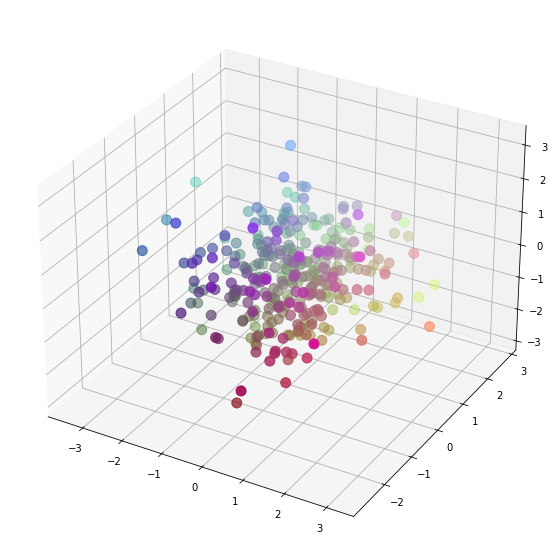

In [12]:
#df['z'].to_numpy()
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# scale Z values for RGB encoding
scaler = MinMaxScaler(feature_range=(0,1))
rgb = scaler.fit_transform(zs)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# get colour channels in 0-1 range
ax.scatter(zs[:, 0], zs[:, 1], zs[:, 2], c=rgb, s=100)
plt.show()



In [19]:
colours = rgb.tolist()

def rgb_to_hex(rgb):
    """Return color as #rrggbb for the given color values."""
    rounded_rgb = tuple(int(round(x)) for x in rgb)
    return '#%02X%02X%02X' % rounded_rgb

hex_colours = [rgb_to_hex(x) for x in colours]
id_to_z['latent_colour'] = hex_colours

In [23]:
id_to_z.to_csv("gfp_extant_annots", sep='\t')

In [15]:

"""
from ete3 import Tree, NodeStyle, TreeStyle



tree = Tree("/scratch/user/s4646506/gfp_alns/ancestor_trees/run_1_ancestors.nwk", 1)
#tree = Tree("(SPG1_STRSG/1-448:1,(UniRef100_Q93EM8/1-351:1,(UniRef100_Q53975/1-351:1,UniRef100_A0A509DAN6/1-448:1):0.5):0.5);")
#print(tree)
print(len(tree))


ts = TreeStyle()

for idx, n in enumerate(tree.traverse()):
    if not n.is_leaf() or n.name not in id_to_z['id']:
        continue

    
    nstyle = NodeStyle()
    nstyle["fgcolor"] = rgb_to_hex(id_to_z[id_to_z['id'] == n.name]['colour'].iloc[0])
    #nstyle['bgcolor'] = rgb_to_hex(df[df['id'] == n.name]['colour'].iloc[0])
    nstyle['size'] = 15
    n.set_style(nstyle)


circular_style = TreeStyle()
circular_style.mode = "c" # draw tree in circular mode
circular_style.scale = 20
tree.show(tree_style=circular_style)
#tree.render("mytree.png", tree_style=circular_style)
t.render("mytree.png", dpi=50, tree_style=circular_style)
"""

SyntaxError: invalid syntax (<ipython-input-15-5ce7b1662709>, line 5)